In [ ]:
import io
import pandas as pd
import numpy as np
from google.colab import files
import warnings
import matplotlib.pyplot as plt
from collections import Counter
import operator
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option('display.max_rows', 100000)
from collections import defaultdict
from itertools import count

In [ ]:
uploaded = files.upload()

Saving 12_22_20_to_12_24_20.csv to 12_22_20_to_12_24_20.csv


In [ ]:
move_history_df =  pd.read_csv(io.BytesIO(uploaded['12_22_20_to_12_24_20.csv']))

In [ ]:
def make_date_index(df):
  df['move_date'] = pd.to_datetime(df['move_date'])
  df.set_index('move_date', inplace=True)
  return df.sort_values(by=['move_date'], inplace=False, ascending=True)  

stow = move_history_df.loc[(move_history_df['requested_by_client'] == 'FCStowAppWebsite')]
stow = make_date_index(stow)
stow = stow.drop(columns= ["region_id", "warehouse_id"])
stow = stow.drop_duplicates(subset='scannable_id', keep='last')
stow.shape[0]

46266

In [ ]:
# Looking at case to cagers data
# Create c2c_df by filtering move_history
c2c_df = move_history_df.loc[move_history_df['requested_by_client'] == 'AFTMoveApp'].drop(columns= ["region_id", "warehouse_id"])

# filtering to get 
c2c_clean = c2c_df.loc[(c2c_df['moved_from'] == 'ws-rcv-pid-1') | (c2c_df['moved_from'] == 'dz-R-idrt') | (c2c_df['moved_from'] == 'dz-P-emptypax') | (c2c_df['moved_from'] == None)].sort_values(by = 'move_date', ascending = True)

In [ ]:
# If all case to cagers were to scan the cases then the differenc would be zero
# too simplistic to look at just the differences in numbers
stow.shape[0] - c2c_clean.shape[0]

20206

In [ ]:
# make a list of all the csXs
stow_csX_ls = stow.scannable_id.to_list()
c2c_csX_ls = c2c_clean.scannable_id.to_list()
#get the common csX between stow and c2c
common_csX = set(c2c_csX_ls).intersection(stow_csX_ls)
len(common_csX)

24976

In [ ]:
# take the difference between c2c and common
c2c_clean.shape[0] - len(common_csX)

1084

In [ ]:
# Number of csX that are lost during this time
unique_to_c2c = c2c_clean[~c2c_clean['scannable_id'].isin(common_csX)]
unique_to_c2c = make_date_index(unique_to_c2c)
unique_to_c2c.shape[0]

1035

In [ ]:
# these are the list of suspeced dirty cages
unique_to_c2c.moved_to.unique()

array(['ve189', 've329', 've136', 've196', 've328', 've433', 've332',
       've235', 've359', 've220', 've253', 've100', 've103', 've127',
       've249', 've401', 've254', 've191', 've483', 've106', 've218',
       've231', 've101', 've241', 've113', 've148', 've114', 've188',
       've360', 've130', 've246', 've208', 've232', 've242', 've222',
       've349', 've203', 've151', 've344', 've219', 've147', 've333',
       've226', 've257', 've133', 've152', 've238', 've236', 've357',
       've322', 've337', 've221', 've215', 've134', 've330', 've230',
       've354', 've194', 've313', 've205', 'P-1-V192J470', 've303',
       've217', 've256', 've190', 've142', 've225', 'P-1-V197L470',
       've351', 've135', 'P-1-V190H402', 've496', 've145', 've195',
       've320', 've239', 've310', 'P-1-V189G500', 'P-1-V188L492',
       'P-1-V189L492', 've202', 've335', 've122', 've312',
       'dz-P-research', 've339', 'dz-P-emptypax', 'dz-R-idrt', 've317',
       've302', 've342', 've193', 've22

In [ ]:
# c2c_ref vehicle specific data for example purposes

#ve = 've253' # got path
#ve = 've332' # got path
#ve = 've353' # These were each received and binded. double check on this later
#ve = 've343' # got path
#ve= 've152'   # got path
#ve = 've226'  # two stowers two packages one is deleted the other doesnt exist
#ve = 've329'
ve = 've100'

c2c_ref = unique_to_c2c[unique_to_c2c.moved_to == ve]
c2c_ref.drop(columns = ['container_move_segment_id', 'container_type'], inplace= True)
#make_date_index(c2c_ref)

In [ ]:
# c2c number of csX making vehicle dirty
c2c_ref.shape[0]

7

In [ ]:
c2c_ref

,scannable_id,moved_from,moved_to,requested_by_client,moved_by
move_date,,,,,
2020-12-22 17:43:50,csXPB3W7F54,ws-rcv-pid-1,ve100,AFTMoveApp,robegarq
2020-12-22 17:44:01,csXPB3WBWQ9,ws-rcv-pid-1,ve100,AFTMoveApp,robegarq
2020-12-22 17:44:05,csXPB3W7F5S,ws-rcv-pid-1,ve100,AFTMoveApp,robegarq
2020-12-23 20:32:40,csXPC9K24D3,ws-rcv-pid-1,ve100,AFTMoveApp,melviroq
2020-12-23 21:15:20,csXPC9K23H4,ws-rcv-pid-1,ve100,AFTMoveApp,habchy
2020-12-23 23:10:24,csXPB3ZVR8L,ws-rcv-pid-1,ve100,AFTMoveApp,lopezlpj
2020-12-23 23:11:33,csXPC9K2ZQN,ws-rcv-pid-1,ve100,AFTMoveApp,lopezlpj


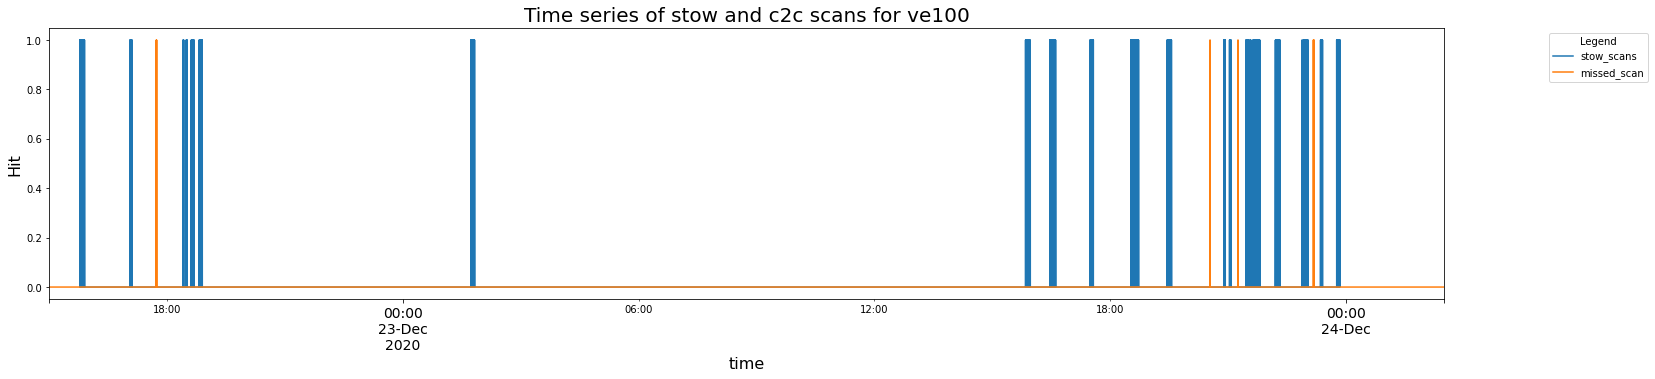

In [ ]:
# make data binary for time series visuals
c2c_ref_binary = unique_to_c2c[unique_to_c2c.moved_to == ve]
c2c_ref_binary["missed_scan"] = 1
c2c_ref_binary.drop(columns = ['container_move_segment_id', 'container_type', 
                                       'scannable_id', 'moved_from', 'moved_to', 
                                       'requested_by_client', 'moved_by']
                                        , inplace = True)
##### Change the times
df_time = pd.DataFrame(index = pd.date_range('2020-12-22 15:00:00','2020-12-24 02:30:00', freq='S'))
c2c_ref_binary = pd.merge(df_time, c2c_ref_binary, left_index = True, right_index = True, how = 'left')
c2c_ref_binary = c2c_ref_binary.resample('S').asfreq().fillna(0)

# stow vehicle specific data
stow_data2inspect = stow[stow.moved_to == ve]
stow_data2inspect.drop(columns = ['container_move_segment_id', 'container_type'], inplace= True)

#############################
ve = c2c_ref.moved_to.iloc[0]
#############################
stow_data2inspect = stow[stow.moved_from== ve]
stow_data2inspect.drop(columns = ['container_move_segment_id', 'container_type',
                               'scannable_id', 'moved_from', 'moved_to',
                               'requested_by_client', 'moved_by']
                               , inplace= True)

stow_data2inspect['stow_scans'] = 1
stow_data2inspect_binary = stow_data2inspect.resample('S').asfreq().fillna(0)

ax = stow_data2inspect_binary.plot()

c2c_ref_binary.plot(ax=ax, figsize=(25,5))

plt.title("Time series of stow and c2c scans for "+ str(ve) , fontsize=20)
plt.legend(title= 'Legend', loc = 'upper right', bbox_to_anchor=(1.15, 1))
plt.xlabel('time', fontsize=16)
plt.ylabel('Hit', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.show()

# Generate pathway

In [ ]:
# Here is a simple function to get all the problem cases and backtrack to potential offenders
ve = c2c_ref.moved_to.iloc[0]
stow_data2inspect = stow[stow.moved_from == ve]
stow_data2inspect.drop(columns = ['container_move_segment_id', 'container_type',
                               'scannable_id', 'moved_from', 'moved_to',
                               'requested_by_client']
                               , inplace= True)

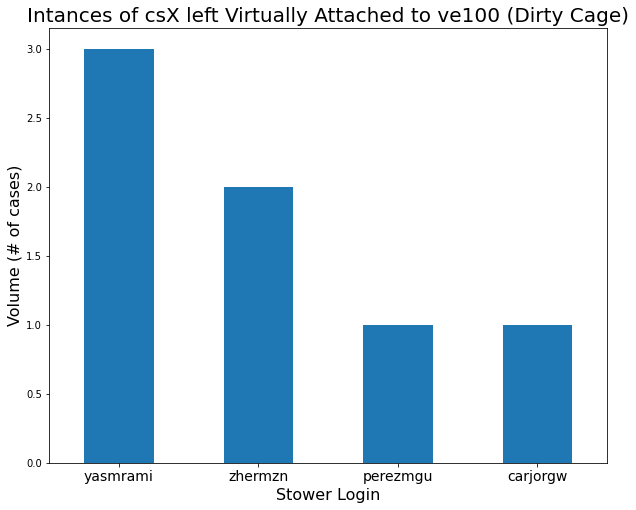

In [ ]:
date_idx = c2c_ref_binary.loc[c2c_ref_binary['missed_scan'] == 1].index
#date_idx = c2c_ref.index

stow_offenders = [] 
stowtimes = []  #
for i in date_idx:
  try:
    stow_offender = stow_data2inspect[stow_data2inspect.index > i].head(1)
    name = stow_offender.moved_by.iloc[0]
    stow_offenders.append(name)

    date = stow_offender.iloc[0] #
    stowtimes.append(date)       #
  except Exception:
    pass




# plot the frequency per c2cers
try:
  scan_counts = Counter(stow_offenders)
  scan_counts = {k: v for k, v in sorted(scan_counts.items(), key=lambda item: item[1], reverse=True)}
  df_a = pd.DataFrame.from_dict(scan_counts, orient='index')
  df_a.plot(kind='bar', figsize=(10,8),  width = .5, legend = None)
  plt.title("Intances of csX left Virtually Attached to " + ve + " (Dirty Cage)" , fontsize=20)
  plt.xlabel('Stower Login', fontsize=16)
  plt.ylabel('Volume (# of cases)', fontsize=16)
  plt.xticks(fontsize=14, rotation=0)
  plt.show()
except:
  pass

In [ ]:
print("list of offenders:", np.unique(stow_offenders))

list of offenders: ['carjorgw' 'perezmgu' 'yasmrami' 'zhermzn']


In [ ]:
c2c_ref

,scannable_id,moved_from,moved_to,requested_by_client,moved_by
move_date,,,,,
2020-12-22 17:43:50,csXPB3W7F54,ws-rcv-pid-1,ve100,AFTMoveApp,robegarq
2020-12-22 17:44:01,csXPB3WBWQ9,ws-rcv-pid-1,ve100,AFTMoveApp,robegarq
2020-12-22 17:44:05,csXPB3W7F5S,ws-rcv-pid-1,ve100,AFTMoveApp,robegarq
2020-12-23 20:32:40,csXPC9K24D3,ws-rcv-pid-1,ve100,AFTMoveApp,melviroq
2020-12-23 21:15:20,csXPC9K23H4,ws-rcv-pid-1,ve100,AFTMoveApp,habchy
2020-12-23 23:10:24,csXPB3ZVR8L,ws-rcv-pid-1,ve100,AFTMoveApp,lopezlpj
2020-12-23 23:11:33,csXPC9K2ZQN,ws-rcv-pid-1,ve100,AFTMoveApp,lopezlpj


In [ ]:
c2c_ref.scannable_id[1]

'csXPB3WBWQ9'

In [ ]:
i = 4

t_startStow = pd.DataFrame(stowtimes).index
#
path = stow.loc[(stow.index >= t_startStow[i]) & (stow.moved_by == stow_offenders[i])  & (stow.moved_from == ve)]


# couple or pivot to find csx based on common paths (bins)
pd.DataFrame(path.moved_to.unique())

,0
0,P-1-V114D202
1,P-1-V115K212
2,P-1-V115L212
3,P-1-V114H490
4,P-1-V113J532
5,P-1-V113J492
6,P-1-V113G492
7,P-1-V113G472
8,P-1-V113K472
9,P-1-V112G472


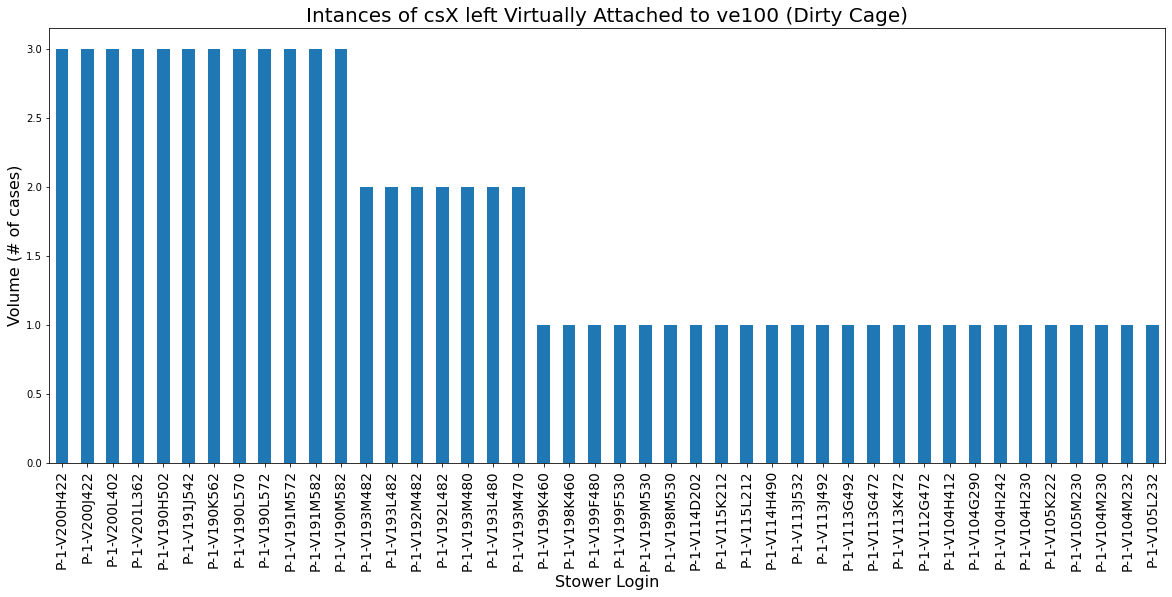

In [ ]:
x = pd.DataFrame()
for i in range(len(c2c_ref)):
  t_startStow = pd.DataFrame(stowtimes).index
  #
  path = stow.loc[(stow.index >= t_startStow[i]) & (stow.moved_by == stow_offenders[i])  & (stow.moved_from == ve)]
  # couple or pivot to find csx based on common paths (bins)
  path = pd.DataFrame(path.moved_to.unique())
  col = c2c_ref.scannable_id[i]
  path.rename(columns={0: col})
  x = x.append(path)

# combine all paths and get 
#pd.DataFrame((x[0].unique()))

# plot the frequency per c2cers
try:
  scan_counts = Counter(x[0])
  scan_counts = {k: v for k, v in sorted(scan_counts.items(), key=lambda item: item[1], reverse=True)}
  df_a = pd.DataFrame.from_dict(scan_counts, orient='index')
  df_a.plot(kind='bar', figsize=(20,8),  width = .5, legend = None)
  plt.title("Intances of csX left Virtually Attached to " + ve + " (Dirty Cage)" , fontsize=20)
  plt.xlabel('Stower Login', fontsize=16)
  plt.ylabel('Volume (# of cases)', fontsize=16)
  plt.xticks(fontsize=14, rotation=90)
  plt.show()
except:
  pass

In [ ]:
x = pd.DataFrame()
for i in range(len(c2c_ref)):
  t_startStow = pd.DataFrame(stowtimes).index
  #
  path = stow.loc[(stow.index >= t_startStow[i]) & (stow.moved_by == stow_offenders[i])  & (stow.moved_from == ve)]
  # couple or pivot to find csx based on common paths (bins)
  path = pd.DataFrame(path.moved_to.unique())
  col = c2c_ref.scannable_id[i]
  path.rename(columns={ path.columns[0]: col })
  print(" ")
  print(col)
  print(path)


 
csXPB3W7F54
               0
0   P-1-V200H422
1   P-1-V200J422
2   P-1-V200L402
3   P-1-V201L362
4   P-1-V190H502
5   P-1-V191J542
6   P-1-V190K562
7   P-1-V190L570
8   P-1-V190L572
9   P-1-V191M572
10  P-1-V191M582
11  P-1-V190M582
 
csXPB3WBWQ9
               0
0   P-1-V200H422
1   P-1-V200J422
2   P-1-V200L402
3   P-1-V201L362
4   P-1-V190H502
5   P-1-V191J542
6   P-1-V190K562
7   P-1-V190L570
8   P-1-V190L572
9   P-1-V191M572
10  P-1-V191M582
11  P-1-V190M582
 
csXPB3W7F5S
               0
0   P-1-V200H422
1   P-1-V200J422
2   P-1-V200L402
3   P-1-V201L362
4   P-1-V190H502
5   P-1-V191J542
6   P-1-V190K562
7   P-1-V190L570
8   P-1-V190L572
9   P-1-V191M572
10  P-1-V191M582
11  P-1-V190M582
 
csXPC9K24D3
              0
0  P-1-V199K460
1  P-1-V198K460
2  P-1-V199F480
3  P-1-V199F530
4  P-1-V199M530
5  P-1-V198M530
 
csXPC9K23H4
               0
0   P-1-V114D202
1   P-1-V115K212
2   P-1-V115L212
3   P-1-V114H490
4   P-1-V113J532
5   P-1-V113J492
6   P-1-V113G492
7   P-1-V113G472
8 

It is more probable to find cases with shorter paths so prioritize the paths. 
Compare this by concatinating all paths and seeing which bins were hit the most, deeming them the most probable defect. 

Experiment on its way. 